In [3]:
import pickle
from pathlib import Path
import sys
sys.path.append("../..")
import matplotlib.pyplot as plt
import torch
import pandas as pd
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run, finetune
import neuralhydrology.datasetzoo.hysets as hs 
from neuralhydrology.utils.config import Config

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

from neuralhydrology.utils.run_analysis import eval_all_runs

from neuralhydrology.datautils.clusterutils import cluster_basin_attributes

In [15]:


# Load configuration
cfg = Config(Path("hysets_basins.yml"))

# Load basin boundaries and filter for HYDAT source
boundaries = hs.load_hysets_boundaries(data_dir = cfg.data_dir)
boundaries = boundaries.loc[boundaries.Source == "HYDAT",:]

# Load data availability and filter basins with sufficient data
availability = pd.read_csv("availability.csv", index_col=0, parse_dates=True)
idx = availability.mean(axis=1) > 0.1
basins = availability.index[idx].to_list()

# Load basin attributes
attributes = hs.load_hysets_attributes(data_dir = cfg.data_dir, augmented=True)
attributes = attributes.loc[basins,:]
attributes_std = attributes.std()
nan_or_zero = attributes_std[~((attributes_std.isna()) | (attributes_std == 0))]
attributes = attributes.loc[:,nan_or_zero.index.to_list()]
idx = (attributes.loc[basins,:].isna().mean() != 0).values
attributes = attributes.loc[:,~idx]

# Find Credit River basins (example for required basins)
boundaries = boundaries.loc[boundaries.Source == "HYDAT",:]
idx = ["credit river" in basin.lower() for basin in boundaries["Name"].to_list()]
cvc_basins = boundaries.index[idx].to_list()

# Cluster basins and select representatives
selected_basins = cluster_basin_attributes(attributes.loc[basins,:], n=64, k=4, random_state=0, required_basins=cvc_basins)

# Save selected basins to file
with open(f"km_{len(selected_basins)}.txt", "w") as f:
    for basin in selected_basins:
        f.write(f"{basin}\n")

Cluster
3    635
0    603
2    449
1     85
Name: count, dtype: int64
True
62
64
64
64


C:\Users\everett\AppData\Local\Temp\ipykernel_15168\1079083018.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  availability = pd.read_csv("availability.csv", index_col=0, parse_dates=True)


In [17]:
len(selected_basins[0])

256

In [12]:
cvc_basins[1] in selected_basins[0]

True

In [9]:
Path("data_export").mkdir(exist_ok=True)
output_dir = Path("data_export")
hs.load_hysets_boundaries(data_dir=cfg.data_dir).loc[selected_basins,:].set_crs(epsg=4326).to_file(output_dir / "cvc_boundaries.geojson", driver="GeoJSON")
hs.load_hysets_attributes(data_dir=cfg.data_dir).loc[cvc_basins,:].to_csv(output_dir / "cvc_attributes.csv")

for basin in cvc_basins:
    df = hs.load_hysets_timeseries(data_dir=cfg.data_dir, basin=basin)
    df.to_csv(output_dir / f"dynamic-data_{basin}.csv")

In [71]:
with open("cvc_basins.txt", "w") as f:
    for basin in cvc_basins:
        f.write(f"{basin}\n")

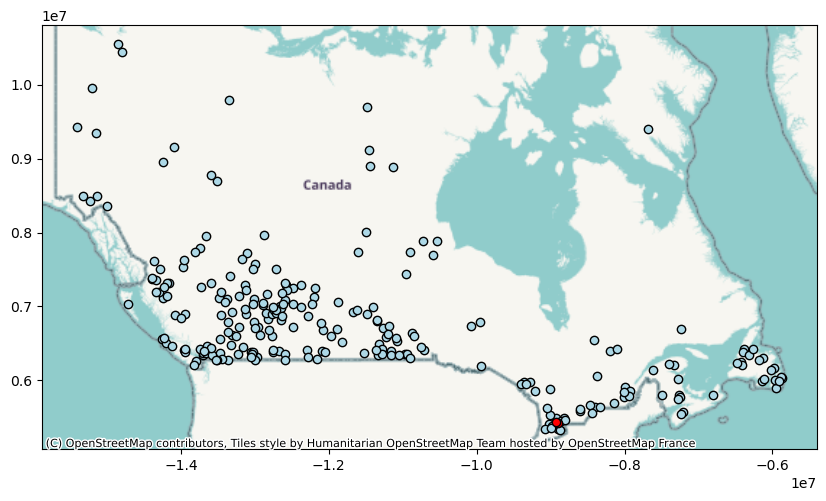

In [90]:
import contextily as ctx

# Plot centroids in Web Mercator (EPSG:3857)
boundaries_wgs = boundaries.set_crs(epsg=4326)
boundaries_merc = boundaries_wgs.to_crs(epsg=3857)
ax = boundaries_merc.loc[selected_basins].centroid.plot(figsize=(10, 8), color="lightblue", edgecolor="black")
boundaries_merc.loc[cvc_basins].centroid.plot(ax=ax, color="red", edgecolor="black")
ctx.add_basemap(ax, crs=boundaries.crs)

In [3]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU
cfg = Config(Path("hysets_basins.yml"))
cfg.update_config({
"train_basin_file":"km_256.txt",
    "validation_basin_file":"km_256.txt",
    "test_basin_file":"km_256.txt"
    })

if Path("config.yml").exists():
    Path("config.yml").unlink()
    
cfg.dump_config(folder=Path())

start_run(config_file=Path("config.yml"))

2025-08-14 00:16:10,310: Logging to c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\hysets_1408_001610\output.log initialized.
2025-08-14 00:16:10,310: ### Folder structure created at c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\hysets_1408_001610
2025-08-14 00:16:10,311: ### Run configurations for hysets
2025-08-14 00:16:10,312: allow_subsequent_nan_losses: 4
2025-08-14 00:16:10,312: batch_size: 256
2025-08-14 00:16:10,312: clip_gradient_norm: 1
2025-08-14 00:16:10,313: clip_targets_to_zero: ['discharge']
2025-08-14 00:16:10,313: data_dir: F:\Data\LSH\HYSETS_2023
2025-08-14 00:16:10,314: dataset: hysets
2025-08-14 00:16:10,314: device: cuda:0
2025-08-14 00:16:10,315: dynamic_inputs: ['2m_dewpoint', '2m_tasmax', '2m_tasmin', 'evaporation', 'surface_net_solar_radiation', 'surface_net_thermal_radiation', 'surface_pressure', 'surface_downwards_solar_radiation', 'surface_downwards_thermal_radiation', 'total_cloud_cover', 'tot

In [72]:
finetune(config_file=Path("transfer.yml"))

2025-08-13 12:32:57,026: Logging to c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\mts_finetuned_1308_123257\output.log initialized.
2025-08-13 12:32:57,027: ### Folder structure created at c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\mts_finetuned_1308_123257
2025-08-13 12:32:57,027: ### Start finetuning with pretrained model stored in c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\hysets_1108_235726
2025-08-13 12:32:57,028: ### Run configurations for mts_finetuned
2025-08-13 12:32:57,028: allow_subsequent_nan_losses: 4
2025-08-13 12:32:57,029: batch_size: 256
2025-08-13 12:32:57,029: clip_gradient_norm: 1
2025-08-13 12:32:57,029: clip_targets_to_zero: ['discharge']
2025-08-13 12:32:57,030: commit_hash: 221d95d
2025-08-13 12:32:57,030: data_dir: F:\Data\LSH\HYSETS_2023
2025-08-13 12:32:57,031: dataset: hysets
2025-08-13 12:32:57,031: device: cuda:0
2025-08-13 12:32:57,031: dynamic_inputs:

2025-08-13 12:32:57,034: hidden_size: 128
2025-08-13 12:32:57,034: img_log_dir: c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\mts_finetuned_1308_123257\img_log
2025-08-13 12:32:57,035: initial_forget_bias: 3
2025-08-13 12:32:57,036: learning_rate: {0: 0.0005, 2: 5e-05}
2025-08-13 12:32:57,036: log_interval: 5
2025-08-13 12:32:57,037: log_n_figures: 1
2025-08-13 12:32:57,037: log_tensorboard: True
2025-08-13 12:32:57,038: loss: NSE
2025-08-13 12:32:57,038: metrics: ['NSE', 'KGE', 'PI']
2025-08-13 12:32:57,039: model: cudalstm
2025-08-13 12:32:57,039: num_workers: 8
2025-08-13 12:32:57,041: number_of_basins: 2
2025-08-13 12:32:57,041: optimizer: Adam
2025-08-13 12:32:57,042: output_activation: linear
2025-08-13 12:32:57,042: output_dropout: 0.4
2025-08-13 12:32:57,042: package_version: 1.12.0
2025-08-13 12:32:57,043: predict_last_n: 1
2025-08-13 12:32:57,043: run_dir: c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\mts_finet

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\training\basetrainer.py:160: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  se

RuntimeError: Error(s) in loading state_dict for CudaLSTM:
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([512, 302]) from checkpoint, the shape in current model is torch.Size([512, 48]).

In [2]:
evaluate_all_runs(Path("runs"))

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\utils\run_analysis.py:114: UserWarning: Failed to load 3 runs: [('hysets_1108_180401', "No config file found matching patterns: ['config.yml']"), ('hysets_1108_180454', "No config file found matching patterns: ['config.yml']"), ('mts_finetuned_1308_123257', "No config file found matching patterns: ['config.yml']")]
  warnings.warn(f"Failed to load {len(failed_runs)} runs: {failed_runs}")


skipping c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\hysets_1108_235726 for period train as it already exists
skipping c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\hysets_1108_235726 for period test as it already exists


c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.

# Evaluation:  15%|█▍        | 38/256 [06:17<36:18,  9.99s/it] 

The following basins had not enough valid target values to calculate a standard deviation: 02PC009. NSE loss values for this basin will be NaN.


# Evaluation:  16%|█▌        | 40/256 [06:37<36:08, 10.04s/it]

The following basins had not enough valid target values to calculate a standard deviation: 02PK005. NSE loss values for this basin will be NaN.


# Evaluation:  16%|█▌        | 41/256 [06:47<35:48, 10.00s/it]

The following basins had not enough valid target values to calculate a standard deviation: 02PL007. NSE loss values for this basin will be NaN.


# Evaluation:  16%|█▋        | 42/256 [06:57<35:34,  9.98s/it]

The following basins had not enough valid target values to calculate a standard deviation: 02PL009. NSE loss values for this basin will be NaN.


# Evaluation:  40%|████      | 103/256 [16:50<24:30,  9.61s/it]

The following basins had not enough valid target values to calculate a standard deviation: 05HF014. NSE loss values for this basin will be NaN.


# Evaluation:  88%|████████▊ | 224/256 [36:31<05:07,  9.61s/it]

The following basins had not enough valid target values to calculate a standard deviation: 08ND019. NSE loss values for this basin will be NaN.


# Evaluation:  95%|█████████▍| 242/256 [39:23<02:11,  9.41s/it]

The following basins had not enough valid target values to calculate a standard deviation: 09FB002. NSE loss values for this basin will be NaN.


# Evaluation: 100%|██████████| 256/256 [41:34<00:00,  9.74s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


# Evaluation:  15%|█▍        | 38/256 [06:04<34:56,  9.62s/it]

The following basins had not enough valid target values to calculate a standard deviation: 02PC009. NSE loss values for this basin will be NaN.


# Evaluation:  16%|█▌        | 40/256 [06:24<35:24,  9.84s/it]

The following basins had not enough valid target values to calculate a standard deviation: 02PK005. NSE loss values for this basin will be NaN.


# Evaluation:  16%|█▌        | 41/256 [06:34<35:22,  9.87s/it]

The following basins had not enough valid target values to calculate a standard deviation: 02PL007. NSE loss values for this basin will be NaN.


# Evaluation:  16%|█▋        | 42/256 [06:44<35:17,  9.89s/it]

The following basins had not enough valid target values to calculate a standard deviation: 02PL009. NSE loss values for this basin will be NaN.


# Evaluation:  17%|█▋        | 43/256 [06:54<34:52,  9.82s/it]

The following basins had not enough valid target values to calculate a standard deviation: 02QA002. NSE loss values for this basin will be NaN.


# Evaluation:  18%|█▊        | 45/256 [07:13<33:59,  9.67s/it]

The following basins had not enough valid target values to calculate a standard deviation: 02RF002. NSE loss values for this basin will be NaN.


# Evaluation:  40%|████      | 103/256 [16:24<24:23,  9.56s/it]

The following basins had not enough valid target values to calculate a standard deviation: 05HF014. NSE loss values for this basin will be NaN.


# Evaluation:  44%|████▍     | 113/256 [17:58<22:11,  9.31s/it]

The following basins had not enough valid target values to calculate a standard deviation: 05LG006. NSE loss values for this basin will be NaN.


# Evaluation:  67%|██████▋   | 172/256 [27:11<12:43,  9.09s/it]

The following basins had not enough valid target values to calculate a standard deviation: 08AB002. NSE loss values for this basin will be NaN.


# Evaluation:  72%|███████▏  | 184/256 [29:01<11:07,  9.27s/it]

The following basins had not enough valid target values to calculate a standard deviation: 08FB007. NSE loss values for this basin will be NaN.


# Evaluation:  88%|████████▊ | 224/256 [35:19<05:00,  9.39s/it]

The following basins had not enough valid target values to calculate a standard deviation: 08ND019. NSE loss values for this basin will be NaN.


# Evaluation: 100%|██████████| 256/256 [40:18<00:00,  9.45s/it]


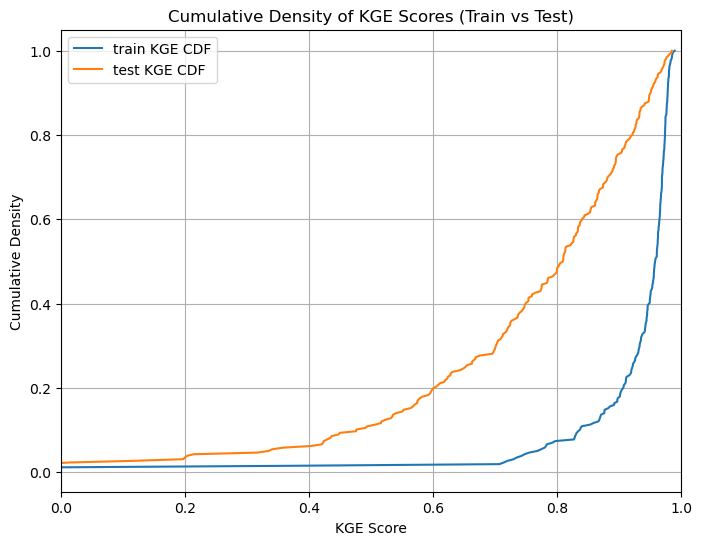

In [ ]:
import numpy as np
# Load train results (update path as needed)
run_name = "hysets_1108_235726"

plt.figure(figsize=(8, 6))


for split in ["train", "test"]:
    results = pd.read_pickle(Path("runs") / run_name / f"{split}/model_epoch128" / f"{split}_results.p")

# Extract KGE metric for each basin in train
    kge_scores = {basin: results[basin]['1D']['KGE'] for basin in results if 'KGE' in results[basin]['1D']}
    scores = np.array(list(kge_scores.values()))
    scores_sorted = np.sort(scores)
    cum_density = np.arange(1, len(scores_sorted) + 1) / len(scores_sorted)

# Test results already loaded as scores_sorted and cum_density

    plt.plot(scores_sorted, cum_density, label=f"{split} KGE CDF")
    
plt.xlabel("KGE Score")
plt.ylabel("Cumulative Density")
plt.title("Cumulative Density of KGE Scores (Train vs Test)")
plt.grid(True)
plt.legend()
plt.xlim(0,1)
plt.show()

In [105]:
test_results

{'01AF007': {'1D': {'xr': <xarray.Dataset>
   Dimensions:        (date: 4383, time_step: 1)
   Coordinates:
     * date           (date) datetime64[ns] 2006-10-01 2006-10-02 ... 2018-09-30
     * time_step      (time_step) int64 0
   Data variables:
       discharge_obs  (date, time_step) float32 1.134 0.7813 ... 0.4341 0.3262
       discharge_sim  (date, time_step) float32 0.9744 0.7613 ... 0.6826 0.5328,
   'NSE': 0.8144010603427887,
   'KGE': 0.8945661587875987,
   'PI': 0.05106323957443237}},
 '01AJ004': {'1D': {'xr': <xarray.Dataset>
   Dimensions:        (date: 4383, time_step: 1)
   Coordinates:
     * date           (date) datetime64[ns] 2006-10-01 2006-10-02 ... 2018-09-30
     * time_step      (time_step) int64 0
   Data variables:
       discharge_obs  (date, time_step) float32 0.5865 0.6078 ... 0.2941 0.241
       discharge_sim  (date, time_step) float32 0.3259 0.365 ... 0.2746 0.2354,
   'NSE': 0.7993935644626617,
   'KGE': 0.8956864927605478,
   'PI': 0.15000635385513306}

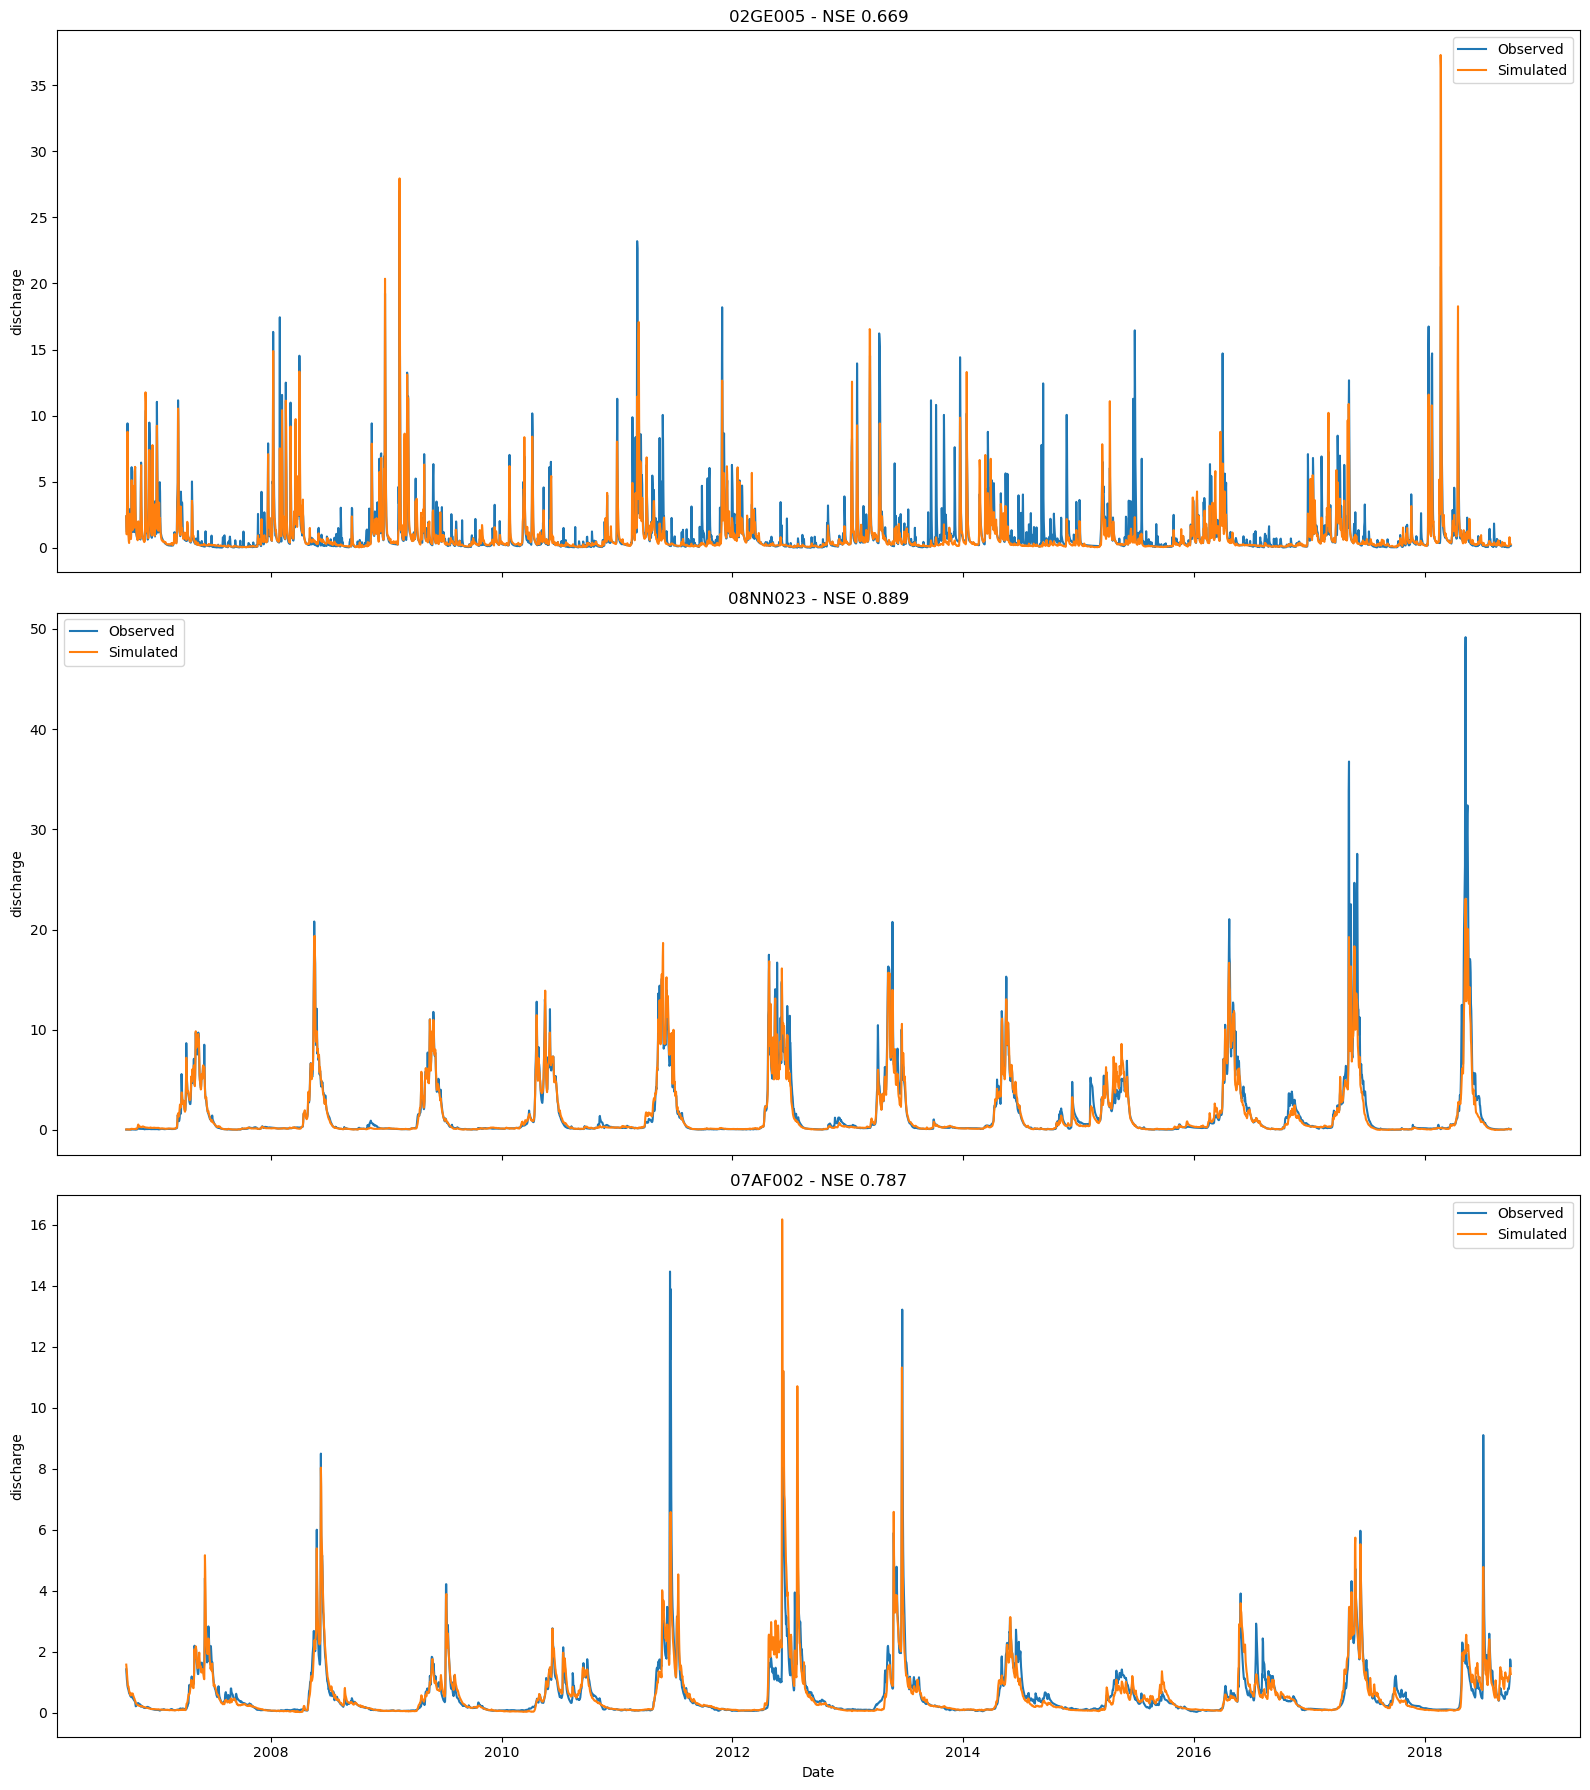

In [ ]:
import random

# Select three random basins from test results

test_results  = pd.read_pickle(Path("runs") / run_name / "test/model_epoch128/test_results.p")



random_basins = random.sample(list(test_results.keys()), 3)

fig, axs = plt.subplots(3, 1, figsize=(16, 18), sharex=True)
for i, basin in enumerate(random_basins):
    qobs = test_results[basin]['1D']['xr']['discharge_obs']
    qsim = test_results[basin]['1D']['xr']['discharge_sim']
    axs[i].plot(qobs['date'], qobs, label='Observed')
    axs[i].plot(qsim['date'], qsim, label='Simulated')
    axs[i].set_ylabel("discharge")
    axs[i].set_title(f"{basin} - NSE {test_results[basin]['1D']['NSE']:.3f}")
    axs[i].legend()


plt.xlabel("Date")
plt.tight_layout()
plt.show()

In [41]:
cvc_basins

['02HB029', '02HB031']

In [38]:
df = hs.load_hysets_timeseries(data_dir=cfg.data_dir, basin=cvc_basins[0])

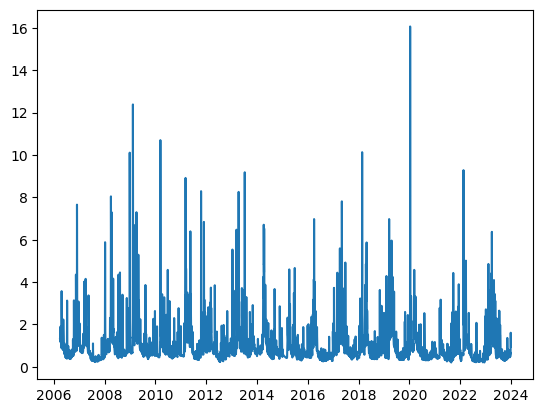

In [40]:
plt.plot(df["discharge"])

In [ ]:
import yaml

output_file = Path(f"{len(basins)}-hysets-basins.txt")

with open(output_file, "w") as file:
    file.write("\n".join(basins))
print(f"Saved {len(basins)} basins to {output_file}")

Saved 2364 basins to 2364-hysets-basins.txt


2025-08-11 23:57:26,599: Logging to c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\hysets_1108_235726\output.log initialized.
2025-08-11 23:57:26,600: ### Folder structure created at c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\hysets_1108_235726
2025-08-11 23:57:26,601: ### Run configurations for hysets
2025-08-11 23:57:26,601: allow_subsequent_nan_losses: 4
2025-08-11 23:57:26,602: batch_size: 256
2025-08-11 23:57:26,602: clip_gradient_norm: 1


2025-08-11 23:57:26,603: clip_targets_to_zero: ['discharge']
2025-08-11 23:57:26,604: data_dir: F:\Data\LSH\HYSETS_2023
2025-08-11 23:57:26,604: dataset: hysets
2025-08-11 23:57:26,605: device: cuda:0
2025-08-11 23:57:26,606: dynamic_inputs: ['2m_dewpoint', '2m_tasmax', '2m_tasmin', 'evaporation', 'surface_net_solar_radiation', 'surface_net_thermal_radiation', 'surface_pressure', 'surface_downwards_solar_radiation', 'surface_downwards_thermal_radiation', 'total_cloud_cover', 'total_precipitation']
2025-08-11 23:57:26,608: epochs: 128
2025-08-11 23:57:26,608: experiment_name: hysets
2025-08-11 23:57:26,608: forcings: ['hysets']
2025-08-11 23:57:26,609: head: regression
2025-08-11 23:57:26,609: hidden_size: 128
2025-08-11 23:57:26,610: initial_forget_bias: 3
2025-08-11 23:57:26,610: learning_rate: {0: 0.001, 10: 0.0005, 20: 0.0001}
2025-08-11 23:57:26,611: log_interval: 5
2025-08-11 23:57:26,612: log_n_figures: 1
2025-08-11 23:57:26,612: log_tensorboard: True
2025-08-11 23:57:26,613: los

In [ ]:
from neuralhydrology.datasetzoo import hysets

from neuralhydrology.modelzoo import Config
import numpy as np
import pandas as pd
from tqdm import tqdm



hysets_dir = Path(r"F:\Data\LSH\HYSETS_2023")
basins = hysets.load_hysets_attributes(data_dir=hysets_dir, metadata=True)
basins = basins.loc[basins["Source"] == "HYDAT",:].index.to_list()


cfg = Config(Path("hysets_basins.yml"))

availability_file = Path() / "data_availability2.csv"

if availability_file.exists():
    avail = pd.read_csv(availability_file, index_col=0)
else:
    prts = ['train','validation','test']
    avail = pd.DataFrame(index=basins, columns=prts)

    for basin in tqdm(basins):
        df = hysets.load_hysets_timeseries(data_dir=hysets_dir, basin=basin)
        for prt in prts:
            tr = slice(getattr(cfg,f'{prt}_start_date'),getattr(cfg,f'{prt}_end_date'))
            n = len(pd.date_range(start=tr.start, end=tr.stop, freq='D'))
            avail.loc[basin, prt] = 1 - df.loc[tr,:].resample("YE").mean().isnull().any(axis=1).mean()

    avail.to_csv(availability_file)

In [7]:
basins = avail.index[np.all(avail > 0.99, axis=1)].to_list()

def list_to_txt(x:list, filename:Path, open_arg="w+"):
    
    output_file = open(filename, open_arg)
    for item in x:
        output_file.write(item + '\n')

basins = basins
list_to_txt(basins, f"{len(basins)}-hysets-basins.txt")

In [8]:
list_to_txt(hysets.load_hysets_attributes(data_dir=hysets_dir, augmented=False).columns.tolist(),hysets_dir.parent / "static_attributes.txt")

### Evaluate run on test set
The run directory that needs to be specified for evaluation is printed in the output log above. Since the folder name is created dynamically (including the date and time of the start of the run) you will need to change the `run_dir` argument according to your local directory name. By default, it will use the same device as during the training process.

In [9]:
run_dir = Path("runs/nse_ar_1811_054939")
eval_run(run_dir=run_dir, period="test", epoch=30)

2025-06-10 20:33:09,186: Using the model weights from runs\nse_ar_1811_054939\model_epoch030.pt


c:\Users\everett\Documents\GitHub\neuralhydrology\examples\07-Canada\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model

# Evaluation:   0%|          | 0/445 [00:00<?, ?it/s]


FileNotFoundError:  Attribute file not found at C:\Users\everett\Documents\GitHub\canada_lsh\data\HYSETS\.HYSETS\HYSETS_watershed_properties.txt

### Load and inspect model predictions
Next, we load the results file and compare the model predictions with observations. The results file is always a pickled dictionary with one key per basin (even for a single basin). The next-lower dictionary level is the temporal resolution of the predictions. In this case, we trained a model only on daily data ('1D'). Within the temporal resolution, the next-lower dictionary level are `xr`(an xarray Dataset that contains observations and predictions), as well as one key for each metric that was specified in the config file.

In [ ]:
run_dir = Path("runs/nse_ar_1811_054939")

with open(run_dir / "test" / "model_epoch030" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['01AD003', '01AF007', '01AJ003', '01AJ004', '01AJ010', '01AK001', '01AK006', '01AK007', '01AL002', '01AL004', '01AM001', '01AN002', '01AP002', '01AP004', '01AQ001', '01BC001', '01BE001', '01BJ003', '01BJ007', '01BJ010', '01BL002', '01BL003', '01BO001', '01BP001', '01BQ001', '01BS001', '01BU002', '01BV006', '01CA003', '01DG003', '01DL001', '01DP004', '01DR001', '01EC001', '01ED007', '01EE005', '01EF001', '01EJ001', '01EO001', '01FA001', '01FB001', '01FB003', '01FJ002', '02AB008', '02AB017', '02AC001', '02AC002', '02AD010', '02BA003', '02BB003', '02BF001', '02BF002', '02BF004', '02CA002', '02CB003', '02CD006', '02CF007', '02CF008', '02CF012', '02DD013', '02DD014', '02DD015', '02EA005', '02EA010', '02EB014', '02EC002', '02EC009', '02ED003', '02ED007', '02FA002', '02FB007', '02FB010', '02FE009', '02FF004', '02FF007', '02FF008', '02GA010', '02GA018', '02GC002', '02GC018', '02GD004', '02GD021', '02GE005', '02GG002', '02GG006', '02GG009', '02GH003', '02HA006', '02HB004', '02HB012',

results.keys()[0]

The data variables in the xarray Dataset are named according to the name of the target variables, with suffix `_obs` for the observations and suffix `_sim` for the simulations.

In [ ]:
list(results.keys())[0]

'01AD003'

Let's plot the model predictions vs. the observations

Text(0.5, 1.0, 'Test period - NSE 0.931')

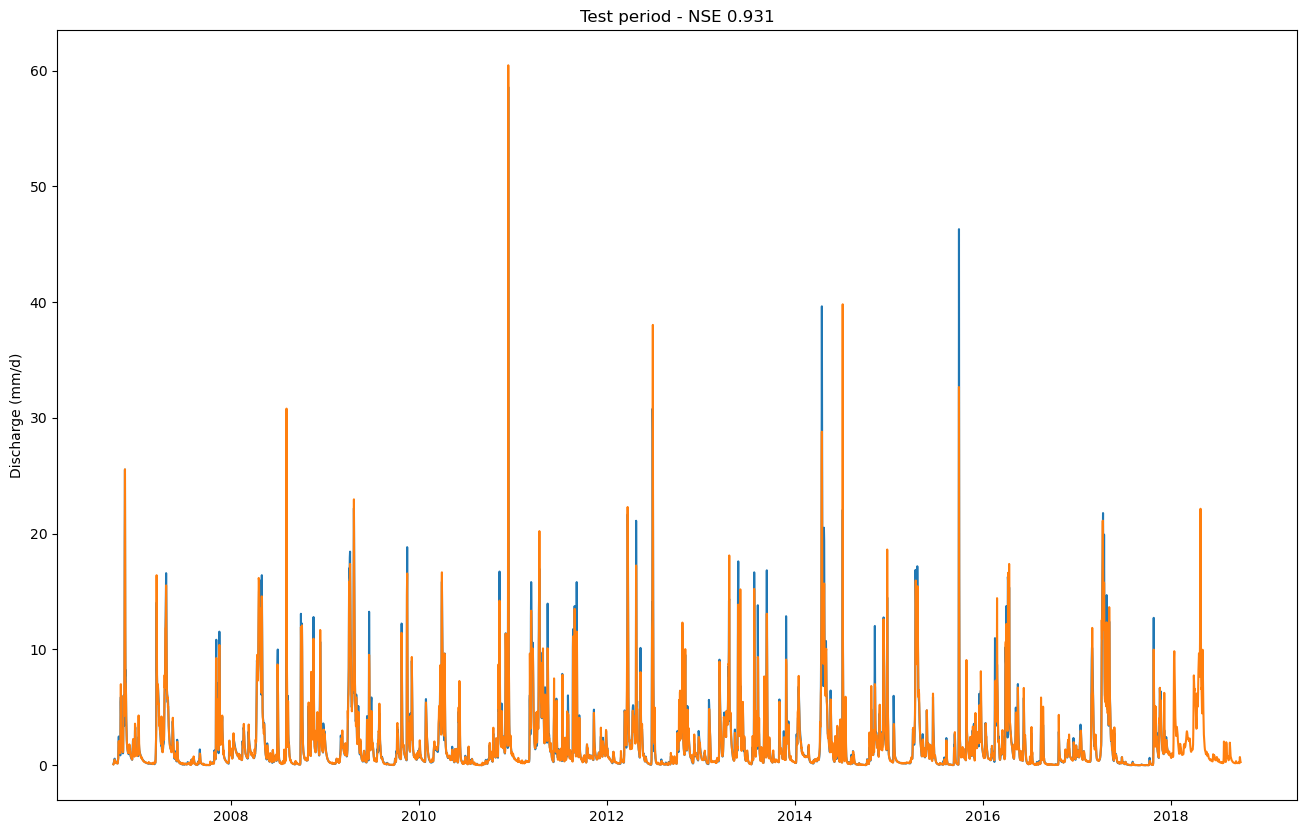

In [ ]:
# extract observations and simulations
qobs = results['01AK007']['1D']['xr']['q(mm/d)_obs']
qsim = results['01AK007']['1D']['xr']['q(mm/d)_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs['date'], qobs)
ax.plot(qsim['date'], qsim)
ax.set_ylabel("Discharge (mm/d)")
ax.set_title(f"Test period - NSE {results['01AK007']['1D']['NSE']:.3f}")

Next, we are going to compute all metrics that are implemented in the NeuralHydrology package. You will find additional hydrological signatures implemented in `neuralhydrology.evaluation.signatures`.

In [ ]:
values = metrics.calculate_all_metrics(qobs.isel(time_step=-1), qsim.isel(time_step=-1))
for key, val in values.items():
    print(f"{key}: {val:.3f}")

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\01-Introduction\../..\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\everett\Documents\GitHub\neuralhydrology\examples\01-Introduction\../..\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


NSE: 0.803
MSE: 0.968
RMSE: 0.984
KGE: 0.871
Alpha-NSE: 0.936
Beta-KGE: 1.044
Beta-NSE: 0.040
Pearson-r: 0.898
FHV: -8.186
FMS: -5.655
FLV: -268.469
Peak-Timing: 0.130
Peak-MAPE: 29.906
